In [1]:
import os
import requests
# import boto3
# import botocore
# from config import cg_headers

import pandas as pd
import numpy as np
from numba import jit
import datetime as dt
import glob
import json

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# import plotly_express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
files = glob.glob('Binance_BTCUSDT*.csv')

perps_data = pd.concat(map(pd.read_csv, files), ignore_index=True)
perps_data['date'] = pd.to_datetime(perps_data['date'])

perps_data = perps_data.sort_values(by='date', inplace=False)
perps_data['symbol'] = "BTCUSDT"
perps_data.head()

,unix,date,symbol,open,high,low,close,volume_BTC,volume_USDT,tradecount
520540,1609459260000,2021-01-01 00:01:00,BTCUSDT,28961.67,29017.50,28961.01,29009.91,58.477501,1.695803e+06,1651
520539,1609459320000,2021-01-01 00:02:00,BTCUSDT,29009.54,29016.71,28973.58,28989.30,42.470329,1.231359e+06,986
520538,1609459380000,2021-01-01 00:03:00,BTCUSDT,28989.68,28999.85,28972.33,28982.69,30.360677,8.800168e+05,959
520537,1609459440000,2021-01-01 00:04:00,BTCUSDT,28982.67,28995.93,28971.80,28975.65,24.124339,6.992262e+05,726
520536,1609459500000,2021-01-01 00:05:00,BTCUSDT,28975.65,28979.53,28933.16,28937.11,22.396014,6.483227e+05,952
...,...,...,...,...,...,...,...,...,...,...
1046145,1676246100000,2023-02-12 23:55:00,BTCUSDT,21756.13,21768.99,21754.10,21765.55,86.255680,1.877174e+06,2209
1046144,1676246160000,2023-02-12 23:56:00,BTCUSDT,21765.55,21785.43,21764.39,21784.58,139.160140,3.030341e+06,3109
1046143,1676246220000,2023-02-12 23:57:00,BTCUSDT,21785.38,21799.69,21783.11,21789.02,179.740460,3.917037e+06,4246
1046142,1676246280000,2023-02-12 23:58:00,BTCUSDT,21790.32,21795.69,21780.24,21783.59,171.155090,3.729105e+06,4259


In [ ]:
premium = pd.read_csv(
    "data\premium_index\BTCUSD2022-2023_premium_rates_1m.csv", usecols=['start_at', 'close'])
premium['start_at'] = pd.to_datetime(
    premium['start_at'], unit='s', origin='unix')
premium = premium.rename(
    columns={'start_at': 'date', 'close': 'premium'})
premium.head()

,date,premium
0,2022-01-01 00:00:00,-0.000033
1,2022-01-01 00:01:00,-0.000188
2,2022-01-01 00:02:00,0.000085
3,2022-01-01 00:03:00,-0.000182
4,2022-01-01 00:04:00,-0.000509
...,...,...
587515,2023-02-12 23:55:00,-0.000662
587516,2023-02-12 23:56:00,-0.000505
587517,2023-02-12 23:57:00,-0.000639
587518,2023-02-12 23:58:00,-0.000465


In [ ]:
clean_df = perps_data.merge(premium, how="inner" , on ="date").reset_index(drop=True)
clean_df

,date,symbol,open,high,low,close,volume_BTC,volume_USDT,tradecount,year,month,day,hour,session,premium
0,2022-01-01 00:00:00,BTCUSDT,46216.93,46271.08,46208.37,46250.00,40.57574,1.875978e+06,796,2022,1,1,0,1,-0.000033
1,2022-01-01 00:01:00,BTCUSDT,46250.00,46344.23,46234.39,46312.76,42.38106,1.961908e+06,973,2022,1,1,0,1,-0.000188
2,2022-01-01 00:02:00,BTCUSDT,46312.76,46381.69,46292.75,46368.73,51.29955,2.377414e+06,1238,2022,1,1,0,1,0.000085
3,2022-01-01 00:03:00,BTCUSDT,46368.73,46391.49,46314.26,46331.08,30.45894,1.412004e+06,953,2022,1,1,0,1,-0.000182
4,2022-01-01 00:04:00,BTCUSDT,46331.07,46336.10,46300.00,46321.34,20.96029,9.710099e+05,591,2022,1,1,0,1,-0.000509


In [ ]:
# perps_data['year'] = perps_data['date'].dt.year
# perps_data['month'] = perps_data['date'].dt.month
# perps_data['day'] = perps_data['date'].dt.day
perps_data['hour'] = perps_data['date'].dt.hour

In [ ]:
def bin_sessions(df, col):
    """Iterates through hours column and assign corresponding funding session.
    New column will contain a number 1-3, representing each funding interval for perpetual contracts (settled every 8 hours).

    Args:
        df (DataFrame): data
        col (str): name of hours column

    Returns:
        DataFrame: dataframe containing new column with approporiate funding session number
    """
    bins = [0, 8, 16, np.inf]
    sessions = [1, 2, 3]
    df['session'] = pd.cut(x=df[col], bins=bins,
                           labels=sessions, include_lowest=True, right=False)
    return df

def get_time_id(df):
    df['time_id'] = (df.index / 15 + 1).astype(int)
    return df

clean_df = bin_sessions(clean_df, 'hour')
clean_df.head()

,unix,date,symbol,open,high,low,close,volume_BTC,volume_USDT,tradecount,year,month,day,hour,session
520540,1609459260000,2021-01-01 00:01:00,BTCUSDT,28961.67,29017.50,28961.01,29009.91,58.477501,1.695803e+06,1651,2021,1,1,0,1
520539,1609459320000,2021-01-01 00:02:00,BTCUSDT,29009.54,29016.71,28973.58,28989.30,42.470329,1.231359e+06,986,2021,1,1,0,1
520538,1609459380000,2021-01-01 00:03:00,BTCUSDT,28989.68,28999.85,28972.33,28982.69,30.360677,8.800168e+05,959,2021,1,1,0,1
520537,1609459440000,2021-01-01 00:04:00,BTCUSDT,28982.67,28995.93,28971.80,28975.65,24.124339,6.992262e+05,726,2021,1,1,0,1
520536,1609459500000,2021-01-01 00:05:00,BTCUSDT,28975.65,28979.53,28933.16,28937.11,22.396014,6.483227e+05,952,2021,1,1,0,1


In [ ]:
def get_time_id(df):
    df['time_id'] = (df.index / 15 + 1).astype(int)
    return df

clean_df=get_time_id(clean_df)
clean_df

,date,symbol,open,high,low,close,volume_BTC,volume_USDT,tradecount,year,month,day,hour,session,premium,vwap
0,2022-01-01 00:06:00,BTCUSDT,46436.03,46518.32,46432.50,46518.31,29.31849,1.362662e+06,1176,2022,1,1,0,1,-0.000251,46358.64
1,2022-01-01 00:07:00,BTCUSDT,46518.31,46527.26,46427.06,46427.95,27.81847,1.292598e+06,810,2022,1,1,0,1,0.000041,46385.25
2,2022-01-01 00:08:00,BTCUSDT,46427.94,46427.97,46383.78,46392.64,15.96245,7.408076e+05,500,2022,1,1,0,1,-0.000385,46400.33
3,2022-01-01 00:09:00,BTCUSDT,46392.64,46406.48,46350.96,46371.11,14.46954,6.710038e+05,489,2022,1,1,0,1,-0.000222,46407.18
4,2022-01-01 00:10:00,BTCUSDT,46369.79,46394.00,46341.55,46379.80,10.65734,4.942085e+05,372,2022,1,1,0,1,-0.000255,46420.24


In [ ]:
def pd_vwap(df):

    vp = df['volume_BTC']*df['close']
    vp_sum = vp.rolling(7).sum()
    v_sum = df['volume_BTC'].rolling(16).sum()
    return (vp_sum/v_sum).round(2)

clean_df['vwap']= pd_vwap(clean_df)
clean_df.head(16)

In [ ]:
def liq_level(df, lev=25, maint=0.005):
    """Calculates liquidation price given the entry price (ma is used here to track price over average of ~1 session where one session = 8hrs
    #Liquidation calculation provided by exchange
    Liquidation Price = ((Price*Leverage)/(Leverage+1 +- (Maintenance Margin * Leverage))) 


    Args:
        df (DataFrame) : a dataframe containing kline data
        lev (int): chosen leverage for perpetual contract
        maint (float): maintanance margin (0.005 for BTCUSD and 0.01 for ETHUSD)*


    Returns:
        long_liq: list of liquidation prices 
        short_liq: list of liquidation prices
    """
    long_liq = []
    short_liq = []
    liq_level_long = 0.0
    liq_level_short = 0.0
    close = df.close
    for price in close:
        liq_level_long = (price*lev)/(lev+1-(maint*lev))
        liq_level_short = (price*lev)/(lev-1+(maint*lev))
        long_liq.append(liq_level_long)
        short_liq.append(liq_level_short)
    return long_liq, short_liq


In [ ]:
clean_df['75_longs'], clean_df['75_shorts'] = liq_level(clean_df, lev=75)
clean_df['50_longs'], clean_df['50_shorts'] = liq_level(clean_df, lev=50)
clean_df['25_longs'], clean_df['25_shorts'] = liq_level(clean_df, lev=25)
clean_df.head()

In [ ]:
def distance_from_liq(low, high, long_liq_level, short_liq_level):

    # percent distance from respective liquidation levels
    distance_to_LL = (low-long_liq_level)/long_liq_level
    distance_to_SL = (high-short_liq_level)/short_liq_level
    return distance_to_LL, distance_to_SL

clean_df['distance_to_LL75'], clean_df['distance_to_SL75'] = distance_from_liq(
    clean_df['low'], clean_df['high'], clean_df['75_longs'], clean_df['75_shorts'])
clean_df['distance_to_LL25'], clean_df['distance_to_SL25'] = distance_from_liq(
    clean_df['low'], clean_df['high'], clean_df['25_longs'], clean_df['25_shorts'])
clean_df['distance_to_LL50'], clean_df['distance_to_SL50'] = distance_from_liq(
    clean_df['low'], clean_df['high'], clean_df['50_longs'], clean_df['50_shorts'])

In [ ]:
# clean_df_slice = clean_df[(clean_df['date'] > '2022-01-02') & (clean_df['date'] <= '2023-01-02')].reset_index(drop=True)

def get_time_id(df):
    return (df.index / 15 + 1).astype(int)

def log_return(close):
    return np.log(close/close.shift(1))
# np.log(df['close']/df['close'].shift(1)).dropna()

clean_df['time_id']=get_time_id(clean_df)
clean_df['log_return'] = log_return(clean_df['close'])

In [ ]:
#  realized volatility(σ) = sqrt of the sum of squared log returns
def realized_vol(df):
    close = df['close']
    lr = log_return(close)
    df['lr_sq'] = lr**2
    rv = df.groupby('time_id')['lr_sq'].sum()
    rv = np.sqrt(rv)
    # df = df.drop(columns ='lr_sq')
    return rv
rv = realized_vol(clean_df)
rv

time_id
1        0.002232
2        0.002058
3        0.002316
4        0.001591
5        0.002534
           ...   
35036    0.000456
35037    0.000884
35038    0.000568
35039    0.000760
35040    0.000580
Name: lr_sq, Length: 35040, dtype: float64

In [ ]:
features_target_df = clean_df.merge(rv, how="inner" , on ="time_id").drop(columns='lr_sq_x').reset_index(drop=True).rename(columns={'lr_sq_y':'RV'})
features_target_df

In [ ]:
features_target_df.columns.values

In [ ]:
# clean_df.to_csv('aggregated_btcusd1m.csv', index=False)

# colab start

In [ ]:
df = pd.read_csv('/content/aggregated_btcusd1m.csv')
df

,unix,date,symbol,open,high,low,close,volume_BTC,volume_USDT,tradecount,...,25_longs,25_shorts,distance_to_LL75,distance_to_SL75,distance_to_LL25,distance_to_SL25,distance_to_LL50,distance_to_SL50,log_return,RV
0,1640995200000,2022-01-01 00:00:00,BTCUSDT,46216.93,46271.08,46208.37,46250.00,40.57574,1.875978e+06,796,...,44685.990338,47927.461140,0.007426,-0.007881,0.034068,-0.034560,0.014086,-0.014551,NaN,0.004583
1,1640995260000,2022-01-01 00:01:00,BTCUSDT,46250.00,46344.23,46234.39,46312.76,42.38106,1.961908e+06,973,...,44746.628019,47992.497409,0.006627,-0.007659,0.033249,-0.034344,0.013282,-0.014331,0.001356,0.004583
2,1640995320000,2022-01-01 00:02:00,BTCUSDT,46312.76,46381.69,46292.75,46368.73,51.29955,2.377414e+06,1238,...,44800.705314,48050.497409,0.006681,-0.008056,0.033304,-0.034730,0.013337,-0.014725,0.001208,0.004583
3,1640995380000,2022-01-01 00:03:00,BTCUSDT,46368.73,46391.49,46314.26,46331.08,30.45894,1.412004e+06,953,...,44764.328502,48011.481865,0.007967,-0.007040,0.034624,-0.033742,0.014632,-0.013716,-0.000812,0.004583
4,1640995440000,2022-01-01 00:04:00,BTCUSDT,46331.07,46336.10,46300.00,46321.34,20.96029,9.710099e+05,591,...,44754.917874,48001.388601,0.007869,-0.008017,0.034523,-0.034693,0.014532,-0.014686,-0.000210,0.004583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587515,1676246100000,2023-02-12 23:55:00,BTCUSDT,21756.13,21768.99,21754.10,21765.55,86.25568,1.877174e+06,2209,...,21029.516908,22554.974093,0.007803,-0.008177,0.034456,-0.034847,0.014466,-0.014844,0.000432,0.001239
587516,1676246160000,2023-02-12 23:56:00,BTCUSDT,21765.55,21785.43,21764.39,21784.58,139.16014,3.030341e+06,3109,...,21047.903382,22574.694301,0.007399,-0.008295,0.034041,-0.034962,0.014059,-0.014962,0.000874,0.001239
587517,1676246220000,2023-02-12 23:57:00,BTCUSDT,21785.38,21799.69,21783.11,21789.02,179.74046,3.917037e+06,4246,...,21052.193237,22579.295337,0.008060,-0.007848,0.034719,-0.034527,0.014725,-0.014518,0.000204,0.001239
587518,1676246280000,2023-02-12 23:58:00,BTCUSDT,21790.32,21795.69,21780.24,21783.59,171.15509,3.729105e+06,4259,...,21046.946860,22573.668394,0.008178,-0.007782,0.034841,-0.034464,0.014844,-0.014453,-0.000249,0.001239


In [ ]:
def liquidated(df, side, leverage = 75, maint=0.005):
    liqed = []
    window = pd.DataFrame()
    # df = df.reset_index()
    if side == 'longs':
        lev_long = f'{leverage}_longs'
        for i in df.index:
            # try:
            print(f'progress: {i}')
            low = df['low'][i]
            window = df.loc[i-30:i, lev_long]
            if any(window.ge(low)):
                liqed.extend([1])
            else:
                liqed.extend([0])
            # except ValueError:
            #     print(f'error: {i}')
            #     liqed.append(0)
    else:
        lev_short = f'{leverage}_shorts'
        for i in df.index:
            print(f'progress: {i}')
            high = df['high'][i]
            window = df.loc[i-30:i, lev_short]
            if any(window.le(high)):
                liqed.extend([1])
            else:
                liqed.extend([0])
    return liqed


In [ ]:
df['75L_liquidated'] = liquidated(df,'longs', 75)
df['75S_liquidated'] = liquidated(df, 'shorts', 75)
df['50L_liquidated'] = liquidated(df, 'longs', 50)
df['50S_liquidated'] = liquidated(df, 'shorts', 50)
df['25L_liquidated'] = liquidated(df, 'longs', 25)
df['25S_liquidated'] = liquidated(df, 'shorts', 25)

In [ ]:
df.to_csv('btcsusd_1m_features1.csv', index=False)

In [ ]:
# BUCKET_NAME = 'btcusdt'
# KEY = 'btcsusd_1m_features1.csv'
# s3 = boto3.resource('s3')

# try:
#   s3.Bucket(BUCKET_NAME).download_file(KEY, 'btcsusd_1m_features1.csv')
# except botocore.exceptions.ClientError as e:
#   if e.response['Error']['Code'] == "404":
#     print("object not found")

In [ ]:
%%time
df.to_parquet('/content/btcsusd_1m_features1.parquet')

CPU times: user 999 ms, sys: 352 ms, total: 1.35 s
Wall time: 1.57 s


In [2]:
%%time
# df = pd.read_parquet('/content/btcsusd_1m_features1.parquet').drop(columns='symbol')
df = pd.read_parquet('/content/btcsusd_1m_features1.parquet')
df.head(5)

CPU times: user 429 ms, sys: 588 ms, total: 1.02 s
Wall time: 829 ms


,unix,date,open,high,low,close,volume_BTC,volume_USDT,tradecount,premium,...,distance_to_LL50,distance_to_SL50,log_return,RV,75L_liquidated,75S_liquidated,50L_liquidated,50S_liquidated,25L_liquidated,25S_liquidated
0,1640995200000,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574,1.875978e+06,796,-0.000033,...,0.014086,-0.014551,NaN,0.004583,0,0,0,0,0,0
1,1640995260000,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106,1.961908e+06,973,-0.000188,...,0.013282,-0.014331,0.001356,0.004583,0,0,0,0,0,0
2,1640995320000,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955,2.377414e+06,1238,0.000085,...,0.013337,-0.014725,0.001208,0.004583,0,0,0,0,0,0
3,1640995380000,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894,1.412004e+06,953,-0.000182,...,0.014632,-0.013716,-0.000812,0.004583,0,0,0,0,0,0
4,1640995440000,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029,9.710099e+05,591,-0.000509,...,0.014532,-0.014686,-0.000210,0.004583,0,0,0,0,0,0


In [3]:
df = df[(df['date'] >= '2022-01-02') & (df['date'] <= '2023-01-02')].reset_index(drop=True)
# data_df=get_time_id(data_df)
df.head()

,unix,date,open,high,low,close,volume_BTC,volume_USDT,tradecount,premium,...,distance_to_LL50,distance_to_SL50,log_return,RV,75L_liquidated,75S_liquidated,50L_liquidated,50S_liquidated,25L_liquidated,25S_liquidated
0,1641081600000,2022-01-02 00:00:00,47722.66,47750.00,47694.68,47740.70,42.12405,2.010188e+06,856,-0.000392,...,0.014022,-0.014808,0.000378,0.002757,0,0,0,0,0,0
1,1641081660000,2022-01-02 00:01:00,47740.70,47740.70,47653.48,47660.81,22.58851,1.077778e+06,850,-0.000269,...,0.014844,-0.013349,-0.001675,0.002757,0,0,0,0,0,0
2,1641081720000,2022-01-02 00:02:00,47660.81,47714.16,47658.59,47687.80,22.11719,1.054642e+06,762,-0.000481,...,0.014378,-0.014456,0.000566,0.002757,0,0,0,0,0,0
3,1641081780000,2022-01-02 00:03:00,47687.80,47728.95,47642.96,47679.48,30.58469,1.458685e+06,832,-0.000537,...,0.014223,-0.013978,-0.000174,0.002757,0,0,0,0,0,0
4,1641081840000,2022-01-02 00:04:00,47679.48,47706.81,47663.70,47672.36,6.42532,3.063591e+05,450,-0.000471,...,0.014816,-0.014288,-0.000149,0.002757,0,0,0,0,0,0


In [ ]:
print(df.describe())
print(df.dtypes)

In [ ]:
df.columns

Index(['unix', 'date', 'open', 'high', 'low', 'close', 'volume_BTC',
       'volume_USDT', 'tradecount', 'premium', 'year', 'month', 'day', 'hour',
       'session', 'time_id', 'vwap', '75_longs', '75_shorts', '50_longs',
       '50_shorts', '25_longs', '25_shorts', 'distance_to_LL75',
       'distance_to_SL75', 'distance_to_LL25', 'distance_to_SL25',
       'distance_to_LL50', 'distance_to_SL50', 'log_return', 'RV',
       '75L_liquidated', '75S_liquidated', '50L_liquidated', '50S_liquidated',
       '25L_liquidated', '25S_liquidated'],
      dtype='object')

In [4]:
etc_cols = ['unix', 'date', 'time_id', 'RV']

agg_func = {'high': 'max', 
            'low': 'min', 
            'volume_BTC':'sum', 
            'volume_USDT': 'sum', 
            'tradecount':'sum', 
            'premium': np.mean, 
            'distance_to_LL75':np.mean, 
            'distance_to_SL75':np.mean, 
            'distance_to_LL50':np.mean,
            'distance_to_SL50':np.mean,
            'distance_to_LL25':np.mean, 
            'distance_to_SL25':np.mean,
            '75L_liquidated': 'max',
            '75S_liquidated': 'max',
            '50L_liquidated': 'max',
            '50S_liquidated': 'max',
            '25L_liquidated': 'max',
            '25S_liquidated': 'max'
            }

time_RV = df[etc_cols].groupby('time_id').first()
close = df.groupby('time_id')['close'].last()
agg_data = df.groupby('time_id').agg(agg_func).reset_index(drop=False)
agg_df = time_RV.merge(agg_data, on='time_id')
agg_df['close'] = close.values
agg_df

,time_id,unix,date,RV,high,low,volume_BTC,volume_USDT,tradecount,premium,...,distance_to_SL50,distance_to_LL25,distance_to_SL25,75L_liquidated,75S_liquidated,50L_liquidated,50S_liquidated,25L_liquidated,25S_liquidated,close
0,97,1641081600000,2022-01-02 00:00:00,0.002757,47750.00,47463.63,294.05935,1.400409e+07,9837,-0.000407,...,-0.014356,0.034507,-0.034369,0,0,0,0,0,0,47517.62
1,98,1641082500000,2022-01-02 00:15:00,0.002071,47578.79,47381.12,324.85868,1.542778e+07,8682,-0.000482,...,-0.014447,0.034493,-0.034458,0,0,0,0,0,0,47544.70
2,99,1641083400000,2022-01-02 00:30:00,0.002317,47699.39,47491.43,266.91970,1.270986e+07,8173,-0.000244,...,-0.014470,0.034472,-0.034481,0,0,0,0,0,0,47638.95
3,100,1641084300000,2022-01-02 00:45:00,0.001666,47700.00,47575.69,196.67044,9.368818e+06,6229,-0.000132,...,-0.014632,0.034497,-0.034640,0,0,0,0,0,0,47625.30
4,101,1641085200000,2022-01-02 01:00:00,0.002355,47641.83,47425.65,138.49194,6.580935e+06,6430,-0.000199,...,-0.014356,0.034747,-0.034369,0,0,0,0,0,0,47442.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,35133,1672614000000,2023-01-01 23:00:00,0.000877,16625.00,16600.80,1034.88397,1.719247e+07,33245,-0.001123,...,-0.014889,0.034823,-0.034891,0,0,0,0,0,0,16617.96
35037,35134,1672614900000,2023-01-01 23:15:00,0.000579,16621.97,16604.65,843.34258,1.401184e+07,30163,-0.000919,...,-0.014862,0.034861,-0.034865,0,0,0,0,0,0,16608.60
35038,35135,1672615800000,2023-01-01 23:30:00,0.000716,16619.20,16602.61,1148.99010,1.908553e+07,35338,-0.000686,...,-0.014833,0.034861,-0.034836,0,0,0,0,0,0,16609.04
35039,35136,1672616700000,2023-01-01 23:45:00,0.000595,16621.44,16603.31,819.39830,1.361085e+07,29652,-0.000572,...,-0.014887,0.034872,-0.034889,0,0,0,0,0,0,16616.75


In [ ]:
agg_df.describe()

,time_id,unix,RV,high,low,volume_BTC,volume_USDT,tradecount,premium,distance_to_LL75,...,distance_to_SL50,distance_to_LL25,distance_to_SL25,75L_liquidated,75S_liquidated,50L_liquidated,50S_liquidated,25L_liquidated,25S_liquidated,close
count,35041.000000,3.504100e+04,35041.000000,35041.000000,35041.000000,35041.000000,3.504100e+04,35041.000000,35041.000000,35041.000000,...,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000,35041.000000
mean,17617.000000,1.656850e+12,0.002719,28206.983835,28078.250701,1527.598223,3.424721e+07,34331.195742,-0.000459,0.007813,...,-0.014479,0.034466,-0.034489,0.143889,0.134585,0.040981,0.036186,0.002426,0.002483,28142.275027
std,10115.609728,9.104049e+09,0.002221,10185.446708,10137.312587,1768.152287,3.480890e+07,32500.434778,0.000283,0.000415,...,0.000428,0.000426,0.000419,0.350982,0.341285,0.198248,0.186756,0.049193,0.049767,10161.478747
min,97.000000,1.641082e+12,0.000135,15712.000000,15476.000000,37.462160,1.134650e+06,2262.000000,-0.006430,-0.000899,...,-0.014974,0.025524,-0.034975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15649.520000
25%,8857.000000,1.648966e+12,0.001425,19538.000000,19467.650000,381.501150,1.306288e+07,9704.000000,-0.000601,0.007694,...,-0.014736,0.034344,-0.034741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19500.670000
50%,17617.000000,1.656850e+12,0.002178,23148.980000,23036.290000,1020.490340,2.437843e+07,25819.000000,-0.000457,0.007917,...,-0.014587,0.034573,-0.034596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23088.190000
75%,26377.000000,1.664734e+12,0.003309,39066.000000,38883.470000,2009.512340,4.287934e+07,48577.000000,-0.000308,0.008065,...,-0.014361,0.034725,-0.034374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38976.000000
max,35137.000000,1.672618e+12,0.062414,48189.840000,47961.000000,40371.405060,8.804418e+08,442735.000000,0.002794,0.008310,...,-0.005961,0.034976,-0.026145,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,48118.480000


In [ ]:
corrmat = agg_df.drop(columns = ['unix','time_id','date'], axis=1).iloc[:,:].corr(method='pearson', min_periods=1000)
corrmat = np.abs(corrmat)
sns.clustermap(corrmat)

NameError: ignored

In [ ]:
corr_target = corrmat['RV'].reset_index()[:-1]
corr_target.columns = ['feature', 'abs_corr']
corr_target = corr_target.sort_values(by='abs_corr', ascending = True).loc[corr_target['abs_corr'] > 0.01]

ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and RV", fontsize = 18)
ax.size
plt.rcParams["figure.autolayout"]=True
plt.show()

In [ ]:
data_df.dtypes

In [11]:
def scaled_neighbors(df,features:list(), n_neighbors, scaler=MinMaxScaler(), get_distance = False):
  """_summary_

  Args:
      df (_type_): _description_
      features (list): _description_
      n_neighbors (_type_): _description_
      scaler (_type_, optional): _description_. Defaults to MinMaxScaler().
      get_distance (bool, optional): _description_. Defaults to False.

  Returns:
      _type_: _description_
  """
  feature_lst = features
  scaler = scaler
  features_df = df[feature_lst]
  X = features_df.values
  X_scaled = scaler.fit_transform(X)
  nn = NearestNeighbors(n_neighbors=n_neighbors)
  nn.fit(X_scaled)
  neighbors = nn.kneighbors()
  nn_idx = neighbors[1]

  if get_distance == True:
    return neighbors 
  else:
    return nn_idx


def agg_neighbors_feature(df, features, n_neighbors, neighbors):
  """_summary_

  Args:
      df (_type_): _description_
      features (_type_): _description_
      n_neighbors (_type_): _description_
      neighbors (_type_): _description_

  Returns:
      _type_: _description_
  """
  feature = str(features)
  nn_df = df[features]
  feature_np = np.zeros(len(neighbors))
  nn_index = int(n_neighbors-1)
  
  for i in range(len(nn_df)):
    for j in range(nn_index):
      feature_np[i] += nn_df.values[neighbors[i][:]].mean()
  return feature_np

# Make granular Nearest Neighbor features

In [6]:
minute_df = df.copy()

In [ ]:
features_lst = ['RV',
                'distance_to_LL75', 
                'distance_to_SL75',
                'distance_to_LL25', 
                'distance_to_SL25',
                'volume_USDT',
                'volume_BTC', 
                'tradecount']

n_neighbor_lst = [5, 10]
nn_idx_dict = {}

for n in n_neighbor_lst:
  nn_idx_dict[n] = scaled_neighbors(minute_df, features = features_lst, n_neighbors=n)

In [ ]:
# nn_idx_dict[5]

array([[114426, 137596, 113256, 111622,  92210],
       [ 89015,  96530,  39613, 226854,  38776],
       [ 22628,  81673,  36479, 101717,   1037],
       ...,
       [510491, 505688, 508770, 499974, 521554],
       [511975, 508914, 515892, 524223, 520484],
       [517388, 519234, 523763, 511809, 524981]])

In [ ]:
minute_nn_features = pd.DataFrame(minute_df['date'], columns = ['date'])
keys = nn_idx_dict.keys()
for key in keys:
  for f in features_lst:
    minute_nn_features[f'{key}nn_avg_{f}'] = agg_neighbors_feature(minute_df, f, n_neighbors=key, neighbors = nn_idx_dict[key])
minute_nn_features

,date,5nn_avg_RV,5nn_avg_distance_to_LL75,5nn_avg_distance_to_SL75,5nn_avg_distance_to_LL25,5nn_avg_distance_to_SL25,5nn_avg_volume_USDT,5nn_avg_volume_BTC,5nn_avg_tradecount,10nn_avg_RV,10nn_avg_distance_to_LL75,10nn_avg_distance_to_SL75,10nn_avg_distance_to_LL25,10nn_avg_distance_to_SL25,10nn_avg_volume_USDT,10nn_avg_volume_BTC,10nn_avg_tradecount
0,2022-01-02 00:00:00,0.010950,0.029307,-0.032731,0.135867,-0.139413,7.640226e+06,184.487520,3577.6,0.024739,0.066146,-0.073342,0.305912,-0.313386,1.758445e+07,431.193879,8042.4
1,2022-01-02 00:01:00,0.011108,0.032797,-0.026529,0.139450,-0.133379,4.285756e+06,115.253472,3162.4,0.024889,0.073859,-0.059966,0.313829,-0.300371,9.194091e+06,240.138144,7278.3
2,2022-01-02 00:02:00,0.011059,0.030839,-0.031041,0.137440,-0.137770,3.870699e+06,95.228824,3012.0,0.025092,0.069425,-0.070003,0.309277,-0.310138,9.173967e+06,219.034953,6940.8
3,2022-01-02 00:03:00,0.011347,0.030306,-0.029243,0.136893,-0.136020,5.701604e+06,143.189328,3268.0,0.025171,0.068088,-0.065642,0.307905,-0.305893,1.201743e+07,313.498638,7884.0
4,2022-01-02 00:04:00,0.011081,0.032544,-0.030460,0.139190,-0.137203,1.341469e+06,32.385512,1846.4,0.025044,0.073285,-0.068565,0.313240,-0.308738,3.202473e+06,77.515425,4055.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525596,2023-01-01 23:56:00,0.002585,0.031505,-0.033017,0.138123,-0.139692,6.282538e+06,365.437296,10771.2,0.005745,0.070817,-0.074460,0.310707,-0.314474,1.412245e+07,829.786608,23891.4
525597,2023-01-01 23:57:00,0.002417,0.033238,-0.032382,0.139902,-0.139075,5.068121e+06,300.521040,10640.8,0.005568,0.074695,-0.072850,0.314687,-0.312908,1.120021e+07,666.051102,24033.6
525598,2023-01-01 23:58:00,0.002358,0.032683,-0.032984,0.139332,-0.139660,4.880831e+06,288.380456,9708.0,0.005398,0.073593,-0.074318,0.313555,-0.314336,1.106778e+07,651.166794,21873.6
525599,2023-01-01 23:59:00,0.002449,0.033106,-0.032514,0.139766,-0.139203,4.188654e+06,250.159016,9880.8,0.005418,0.074457,-0.073232,0.314443,-0.313279,9.438800e+06,563.165793,22122.9


In [ ]:
minute_all_features = minute_df.merge(minute_nn_features, on='date')
minute_all_features.head()



,unix,date,open,high,low,close,volume_BTC,volume_USDT,tradecount,premium,...,5nn_avg_volume_BTC,5nn_avg_tradecount,10nn_avg_RV,10nn_avg_distance_to_LL75,10nn_avg_distance_to_SL75,10nn_avg_distance_to_LL25,10nn_avg_distance_to_SL25,10nn_avg_volume_USDT,10nn_avg_volume_BTC,10nn_avg_tradecount
0,1641081600000,2022-01-02 00:00:00,47722.66,47750.00,47694.68,47740.70,42.12405,2.010188e+06,856,-0.000392,...,184.487520,3577.6,0.024739,0.066146,-0.073342,0.305912,-0.313386,1.758445e+07,431.193879,8042.4
1,1641081660000,2022-01-02 00:01:00,47740.70,47740.70,47653.48,47660.81,22.58851,1.077778e+06,850,-0.000269,...,115.253472,3162.4,0.024889,0.073859,-0.059966,0.313829,-0.300371,9.194091e+06,240.138144,7278.3
2,1641081720000,2022-01-02 00:02:00,47660.81,47714.16,47658.59,47687.80,22.11719,1.054642e+06,762,-0.000481,...,95.228824,3012.0,0.025092,0.069425,-0.070003,0.309277,-0.310138,9.173967e+06,219.034953,6940.8
3,1641081780000,2022-01-02 00:03:00,47687.80,47728.95,47642.96,47679.48,30.58469,1.458685e+06,832,-0.000537,...,143.189328,3268.0,0.025171,0.068088,-0.065642,0.307905,-0.305893,1.201743e+07,313.498638,7884.0
4,1641081840000,2022-01-02 00:04:00,47679.48,47706.81,47663.70,47672.36,6.42532,3.063591e+05,450,-0.000471,...,32.385512,1846.4,0.025044,0.073285,-0.068565,0.313240,-0.308738,3.202473e+06,77.515425,4055.4


In [ ]:
minute_all_features.to_parquet('/content/minute_all_features.parquet')

# Make Nearest Neighbor features 15m data



## Make macro NN features

In [12]:
features_lst = ['RV',
                'distance_to_LL75', 
                'distance_to_SL75',
                'distance_to_LL25', 
                'distance_to_SL25',
                'volume_USDT',
                'volume_BTC', 
                'tradecount']

n_neighbor_lst_15m = [3, 5, 10]
nn_idx_dict_15m = {}

for n in n_neighbor_lst_15m:
  nn_idx_dict_15m[n] = scaled_neighbors(agg_df, features=features_lst, n_neighbors=n)

In [15]:
nn_features_df = pd.DataFrame(agg_df['time_id'], columns = ['time_id'])
keys_15m = nn_idx_dict_15m.keys()
for key in keys_15m:
  for f in features_lst:
    nn_features_df[f'{key}nn_avg_{f}'] = agg_neighbors_feature(agg_df, f, n_neighbors=key, neighbors = nn_idx_dict_15m[key])
nn_features_df

,time_id,3nn_avg_RV,3nn_avg_distance_to_LL75,3nn_avg_distance_to_SL75,3nn_avg_distance_to_LL25,3nn_avg_distance_to_SL25,3nn_avg_volume_USDT,3nn_avg_volume_BTC,3nn_avg_tradecount,5nn_avg_RV,...,5nn_avg_volume_BTC,5nn_avg_tradecount,10nn_avg_RV,10nn_avg_distance_to_LL75,10nn_avg_distance_to_SL75,10nn_avg_distance_to_LL25,10nn_avg_distance_to_SL25,10nn_avg_volume_USDT,10nn_avg_volume_BTC,10nn_avg_tradecount
0,97,0.005526,0.015697,-0.015349,0.069004,-0.068718,2.624797e+07,710.841560,20020.666667,0.010769,...,1503.300968,39805.6,0.024821,0.070695,-0.069093,0.310581,-0.309251,1.221593e+08,3155.255802,90837.0
1,98,0.004088,0.015693,-0.015547,0.069001,-0.068911,2.318242e+07,591.456220,17466.000000,0.008238,...,1162.826368,35190.4,0.019459,0.070617,-0.069993,0.310501,-0.310128,1.194552e+08,2896.157655,83938.5
2,99,0.004637,0.015654,-0.015594,0.068960,-0.068956,2.027327e+07,473.472133,18172.666667,0.009605,...,982.993320,36988.8,0.020849,0.070345,-0.070195,0.310221,-0.310324,1.057117e+08,2570.233590,85450.5
3,100,0.003287,0.015707,-0.015906,0.069015,-0.069260,1.795350e+07,422.515233,14601.333333,0.006994,...,833.482080,26931.2,0.016352,0.070657,-0.071696,0.310543,-0.311785,8.135013e+07,1945.133721,64175.4
4,101,0.004410,0.016180,-0.015377,0.069500,-0.068745,1.742498e+07,420.989113,16596.666667,0.009006,...,902.333528,34261.6,0.021416,0.072583,-0.069197,0.312519,-0.309353,8.387275e+07,2378.987379,75122.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,35133,0.001726,0.016318,-0.016419,0.069642,-0.069759,3.537087e+07,2020.635753,65647.333333,0.003224,...,4161.973192,130721.6,0.006671,0.073477,-0.073931,0.313437,-0.313960,1.605078e+08,9333.352071,292314.6
35037,35134,0.001235,0.016411,-0.016393,0.069737,-0.069734,2.943301e+07,1692.042620,59280.000000,0.002518,...,3409.228344,118460.0,0.005593,0.073744,-0.073772,0.313711,-0.313805,1.316235e+08,7795.657656,265881.6
35038,35135,0.001463,0.016399,-0.016340,0.069725,-0.069682,3.959498e+07,2249.988433,71076.000000,0.002846,...,4523.322624,139964.8,0.006218,0.073781,-0.073503,0.313748,-0.313543,1.761506e+08,10255.980852,318089.7
35039,35136,0.001172,0.016418,-0.016455,0.069745,-0.069794,2.881214e+07,1740.080780,59318.666667,0.002211,...,3362.656680,117798.4,0.005245,0.073880,-0.073957,0.313850,-0.313985,1.267117e+08,7525.667583,267705.9


In [16]:
merged_nn_features = agg_df.merge(nn_features_df, on='time_id')
merged_nn_features.head()

,time_id,unix,date,RV,high,low,volume_BTC,volume_USDT,tradecount,premium,...,5nn_avg_volume_BTC,5nn_avg_tradecount,10nn_avg_RV,10nn_avg_distance_to_LL75,10nn_avg_distance_to_SL75,10nn_avg_distance_to_LL25,10nn_avg_distance_to_SL25,10nn_avg_volume_USDT,10nn_avg_volume_BTC,10nn_avg_tradecount
0,97,1641081600000,2022-01-02 00:00:00,0.002757,47750.00,47463.63,294.05935,1.400409e+07,9837,-0.000407,...,1503.300968,39805.6,0.024821,0.070695,-0.069093,0.310581,-0.309251,1.221593e+08,3155.255802,90837.0
1,98,1641082500000,2022-01-02 00:15:00,0.002071,47578.79,47381.12,324.85868,1.542778e+07,8682,-0.000482,...,1162.826368,35190.4,0.019459,0.070617,-0.069993,0.310501,-0.310128,1.194552e+08,2896.157655,83938.5
2,99,1641083400000,2022-01-02 00:30:00,0.002317,47699.39,47491.43,266.91970,1.270986e+07,8173,-0.000244,...,982.993320,36988.8,0.020849,0.070345,-0.070195,0.310221,-0.310324,1.057117e+08,2570.233590,85450.5
3,100,1641084300000,2022-01-02 00:45:00,0.001666,47700.00,47575.69,196.67044,9.368818e+06,6229,-0.000132,...,833.482080,26931.2,0.016352,0.070657,-0.071696,0.310543,-0.311785,8.135013e+07,1945.133721,64175.4
4,101,1641085200000,2022-01-02 01:00:00,0.002355,47641.83,47425.65,138.49194,6.580935e+06,6430,-0.000199,...,902.333528,34261.6,0.021416,0.072583,-0.069197,0.312519,-0.309353,8.387275e+07,2378.987379,75122.1


In [17]:
merged_nn_features.columns

Index(['time_id', 'unix', 'date', 'RV', 'high', 'low', 'volume_BTC',
       'volume_USDT', 'tradecount', 'premium', 'distance_to_LL75',
       'distance_to_SL75', 'distance_to_LL50', 'distance_to_SL50',
       'distance_to_LL25', 'distance_to_SL25', '75L_liquidated',
       '75S_liquidated', '50L_liquidated', '50S_liquidated', '25L_liquidated',
       '25S_liquidated', 'close', '3nn_avg_RV', '3nn_avg_distance_to_LL75',
       '3nn_avg_distance_to_SL75', '3nn_avg_distance_to_LL25',
       '3nn_avg_distance_to_SL25', '3nn_avg_volume_USDT', '3nn_avg_volume_BTC',
       '3nn_avg_tradecount', '5nn_avg_RV', '5nn_avg_distance_to_LL75',
       '5nn_avg_distance_to_SL75', '5nn_avg_distance_to_LL25',
       '5nn_avg_distance_to_SL25', '5nn_avg_volume_USDT', '5nn_avg_volume_BTC',
       '5nn_avg_tradecount', '10nn_avg_RV', '10nn_avg_distance_to_LL75',
       '10nn_avg_distance_to_SL75', '10nn_avg_distance_to_LL25',
       '10nn_avg_distance_to_SL25', '10nn_avg_volume_USDT',
       '10nn_avg_volum

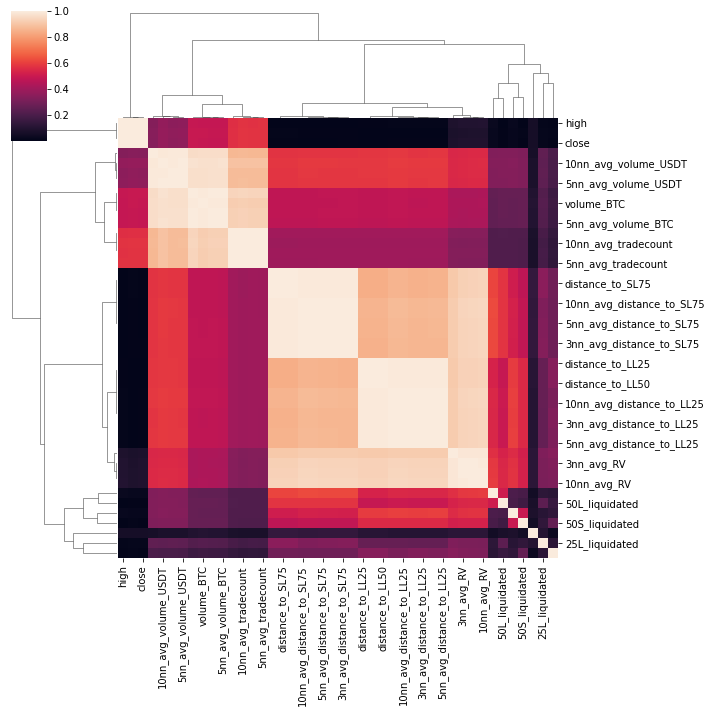

In [18]:
corrmat2 = merged_nn_features.drop(columns = ['unix','time_id'], axis=1).iloc[:,:].corr(method='pearson', min_periods=2500)
corrmat2 = np.abs(corrmat2)
sns.clustermap(corrmat2)

In [ ]:
corr_target = corrmat2['RV'].reset_index()[:-1]
corr_target.columns = ['feature', 'abs_corr']
corr_target = corr_target.sort_values(by='abs_corr', ascending = True).loc[corr_target['abs_corr'] > 0.01]

ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and RV", fontsize = 18)
plt.rcParams["figure.autolayout"]=True
plt.show()

In [19]:
merged_nn_features.to_parquet('/content/btcsusd_15m_features.parquet')